<a href="https://www.kaggle.com/code/megr25/advance-regression-laso-ridge-and-elasticnet?scriptVersionId=113818279" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Main Libraries

### In this notebook you will find:
1. step by step Scrub methodology
2. Outlier Detection
3. Normalization
4. Regression Algorithms (Lasso, Ridge, Linear Regression , SGB )

In [1]:
import pandas as pd 
import tensorflow as tf
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
%matplotlib inline
sns.set_style('whitegrid')
warnings.filterwarnings("ignore")

### Obtain
1. Retrieve information 
2. Find Number of Null / Nan / Invaled Values 
3. Identify target value
4. Define Objective

---------------------------------
- What are the most important variables to determine the final price
- How could this modeling impact business positively 
- What are the future steps to improve /  validate this model 

In [2]:
path  = '../input/kc-housesales-data/kc_house_data.csv'
df = pd.read_csv(path)
print(f"Numbers of nan values are {df.isnull().any().sum()}")
print(f"Columns in this Data set {list(df.columns[:5])}..., where 'Sale Price' is what we want to Predict")
df.head(3)
#df.describe().T

Numbers of nan values are 0
Columns in this Data set ['id', 'date', 'price', 'bedrooms', 'bathrooms']..., where 'Sale Price' is what we want to Predict


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


### Scrub
1. In this section the main objective is get familiar with the data set, make sure everything is standardized for Machine Learning
2. We have to check date time, string, categorical values, continues values , etc

--------------------
Notice that 
- The column ID  is not important because it wont give any important contribution instead it will lead into Overfitting therefore we drop it
- Columns Date must be transformed into Date time format and divided by year/ month 
- We must deal with Long and Lat (Geographical Location)

In [3]:
# The only two columns to be transformed are Date , and then Drop id, Date

# ---- >  Date time 
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda date: date.year)
df['month'] = df['date'].apply(lambda date: date.month)

# ---- > Dropping 
df.drop(['id','date'], axis = 1 , inplace = True)
print("-----------------Transforming Columns -------------------------")

-----------------Transforming Columns -------------------------


### Explore
1. Find trend and relation between price and other factors that might rise the prices 
2. Identify Ouliers 
3. Create Visualization that helps stakesholders to better understand the model 

We can notice that the more bedrooms a house has the more expensive it is
in the second graph we can notice how price is linearly related to sqft living - the bigger the house is the more expensive it will be
In graph 3 - a combination of longitude and latitude plus price segmentation , the darker the color is the more expensive the house would be
Graph 4 confirmes that the house condition seems not to be so significance to set the final price 
Notice *** all those small dots in graph 1, 4 may be Outliers , there fore we have to make some transformation


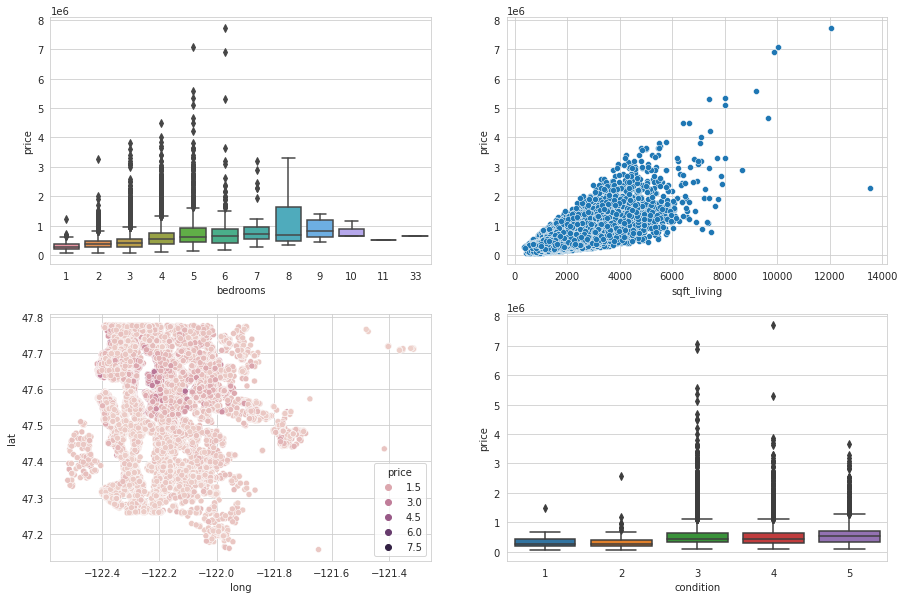

In [4]:
f,ax = plt.subplots(2,2, figsize = (15,10))
y = 'price'
sns.boxplot(x='condition', y=y, data=df , ax = ax[1,1])
sns.scatterplot(x='sqft_living',y=y ,data=df , ax = ax[0,1])
sns.scatterplot(x='long',y='lat',hue=y ,data=df , ax = ax[1,0])
sns.boxplot(x='bedrooms',y=y ,data=df , ax = ax[0,0]);

print('We can notice that the more bedrooms a house has the more expensive it is')
print('in the second graph we can notice how price is linearly related to sqft living - the bigger the house is the more expensive it will be')
print('In graph 3 - a combination of longitude and latitude plus price segmentation , the darker the color is the more expensive the house would be')
print('Graph 4 confirmes that the house condition seems not to be so significance to set the final price ')
print('Notice *** all those small dots in graph 1, 4 may be Outliers , there fore we have to make some transformation')

### Model

1. Find outliers - those houses that are super expensive / super cheap 
2. Apply some statical techniques to transforme some columns 
- For example bathroom = 2.5 we cannot have 2.5 bathrooms we have 2 or 3 
- Another example could be how can we compare house with basement vs no basement
- normallized those columns that dont have normal distribution (check some videos on youtube)
3. Define the ML algorithm that we will use to predict the price

#### Finding Ouliers

In here we use Unsupervised Machine Learning - LocalOutlierFactor -
LocalOutlierFactor : this algorihtm will check each point E.x Price = 20000  and will look for 20 prices near 20000 if it finds those 20 prices it will keep the the point otherwise it will be tag as outlier, of course this will happend in high dimensional space 

number of outliers 954
the ones in red are the outliers, remember that this is two dimmensional graph
which means that in 2D doesnt make that much sense but this is only a representation


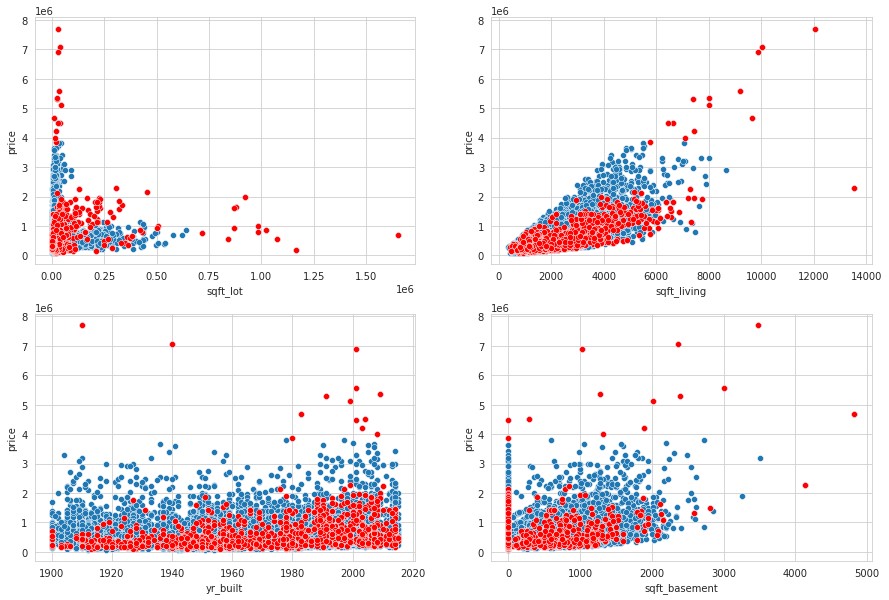

In [5]:
from sklearn.neighbors import LocalOutlierFactor
# ---> Identifying Outliers
LOF = LocalOutlierFactor(n_neighbors=18, novelty = False)
df['Outliers'] = LOF.fit_predict(df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated','sqft_living15','sqft_lot15']])

# Finding outliers 
outliers = df[df['Outliers']==-1].index 
print(f"number of outliers {len(outliers)}")
price_sqft = df.loc[outliers,['price','sqft_basement','sqft_living','yr_built','sqft_lot']]

#Now let's visualized where those outliers were 
f,ax = plt.subplots(2,2, figsize = (15,10))
y = 'price'

sns.scatterplot(x='sqft_basement', y=y, data=df , ax = ax[1,1])
sns.scatterplot(x='sqft_basement', y=y, data=price_sqft , ax = ax[1,1],color = 'r')
sns.scatterplot(x='sqft_living',y=y ,data=df , ax = ax[0,1])
sns.scatterplot(x='sqft_living',y=y ,data=price_sqft , ax = ax[0,1],color = 'r')
sns.scatterplot(x='yr_built',y=y ,data=df , ax = ax[1,0])
sns.scatterplot(x='yr_built',y=y ,data=price_sqft , ax = ax[1,0],color = 'r')
sns.scatterplot(x='sqft_lot',y=y ,data=df , ax = ax[0,0])
sns.scatterplot(x='sqft_lot',y=y ,data=price_sqft , ax = ax[0,0],color = 'r');

#Dropping Outliers
df.drop(df[df['Outliers']==-1].index , inplace=True)
print("the ones in red are the outliers, remember that this is two dimmensional graph")
print("which means that in 2D doesnt make that much sense but this is only a representation")


#### Normalizing data

In this section we will look for some skewed columns ,skewed is when a distribution is not normalized - has bell shape -- 

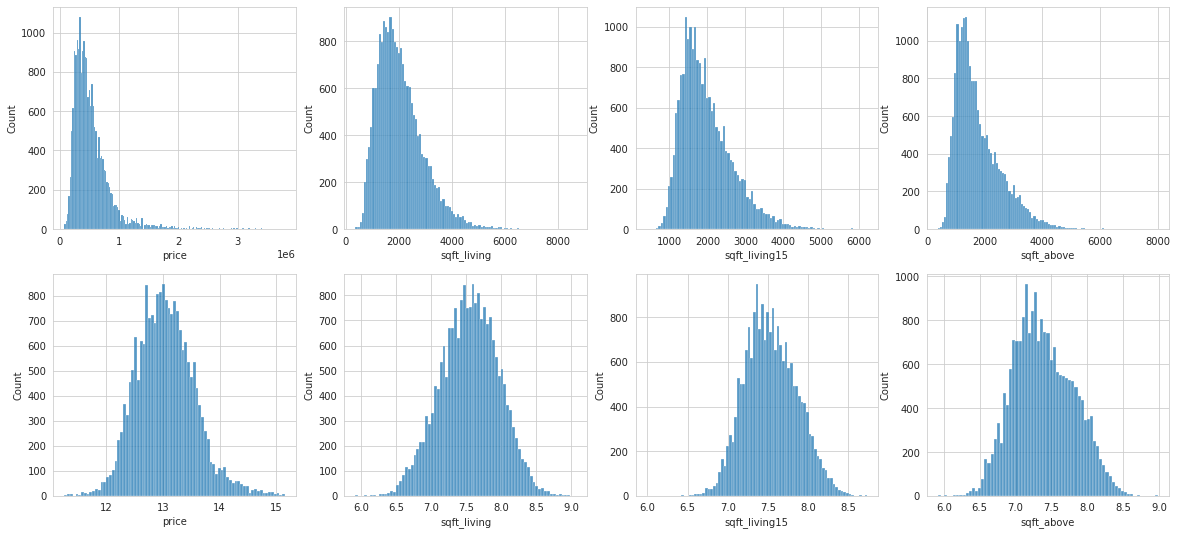

In [6]:
# ------------------------ Before Normalizing ------------------------

f,ax = plt.subplots(2,4, figsize = (20,9))
y = 'price'
sns.histplot(df['price'], ax = ax[0,0])
sns.histplot(df['sqft_living'], ax = ax[0,1])
sns.histplot(df['sqft_living15'], ax = ax[0,2])
sns.histplot(df['sqft_above'], ax = ax[0,3]);

# First -- Identify numerical and categorical columns 
numerical = df.select_dtypes(['int64','float64'])
categorical = df.select_dtypes('object')

#Second  
skw = numerical.skew().abs().sort_values(ascending=True) #skew the data set
columns_skw = skw.loc[skw>0.75] #find those skewed to the right

# ------------------------ After Normalizing ------------------------

# -- Understand that not all of numerical columns must be transformed (e.x year , long, lat)
for i in columns_skw.index:
  if i not in ['year','long']:
    df[i]= np.log1p(df[i]).astype('float')

sns.histplot(df['price'], ax = ax[1,0])
sns.histplot(df['sqft_living'], ax = ax[1,1])
sns.histplot(df['sqft_living15'], ax = ax[1,2])
sns.histplot(df['sqft_above'], ax = ax[1,3]);

#### Finding Coorelation between variables

1. We will try to reduce the curse of dimmensionality by dropping those columns that are related to each other 

In [7]:
FC = numerical.corr() # Features Correlation
Target = numerical.corr()['price'].to_frame().reset_index() #Feature Correlation related to SalePrice
FR = FC.unstack().to_frame(name='Correlation') # Feature Relation
Feature = FR[(FR['Correlation']>=0.8)&(FR['Correlation']<1)].sort_values(by='Correlation', ascending = False).reset_index()
Final  = Feature.merge(Target,left_on='level_1', right_on='index')
print("In thisdata set these columns are strongly related , i will usually take one and drop the other one but in this case i will keep it ")
Final

In thisdata set these columns are strongly related , i will usually take one and drop the other one but in this case i will keep it 


,level_0,level_1,Correlation,index,price
0,sqft_living,sqft_above,0.866961,sqft_above,0.581847
1,sqft_above,sqft_living,0.866961,sqft_living,0.685970
2,sqft_lot,sqft_lot15,0.801804,sqft_lot15,0.057219
3,sqft_lot15,sqft_lot,0.801804,sqft_lot,0.056782


#### Algorithms

1. Base model

  *   Linear Regression
  *   Lasso
  *   Rige
  *   Stochastic Gradient Regressor

2. Scaling and Hyperparameters
3. Mesuaring Performance of Artificial Neural Newtwork - regressor - 

In [8]:
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

### Baseline model
1. No StandarScaler
2. No Hyperparameters

In [9]:
# Base model 
X = df.drop(['price','Outliers'], axis = 1)
y = df['price']

# For SGD
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


KF = KFold(n_splits=4) # Number of split on the Data
X_columns = X.columns.to_list()

performance = {} 
for i in [LinearRegression(), Lasso (), Ridge (), ElasticNet ()]:
  pipe = Pipeline([(str(i.__class__.__name__),i)]) #model name + model Options
  model_pred = cross_val_predict(pipe, X,y, cv = KF)
  Error = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(model_pred)))
  performance[str(i.__class__.__name__)] =round(Error)

# Final Results 
print("The base model - without any parameter tunning shows a MSE of 17K to 35 K")
print("This means that the price that we predict varies +- 17K and 35K in Lasso and ElastnicNet")
pd.DataFrame(performance, index=['Squarred_error']).T.sort_values('Squarred_error')


The base model - without any parameter tunning shows a MSE of 17K to 35 K
This means that the price that we predict varies +- 17K and 35K in Lasso and ElastnicNet


,Squarred_error
LinearRegression,177735
Ridge,177850
Lasso,351263
ElasticNet,351412


### Basemodel + Pipeline + StandarScaler
1. StandarScaler

There are not significant changes, except for Lasso by having 23 less MSE
                  Squarred_error  Sqrd_scaler
LinearRegression          177735       177735
Ridge                     177850       177738
Lasso                     351263       351239
ElasticNet                351412       351239


In here we can see that the regularization in ElastincNet and Lasso lambda where not the ebst parameter that is why we had that horizontal


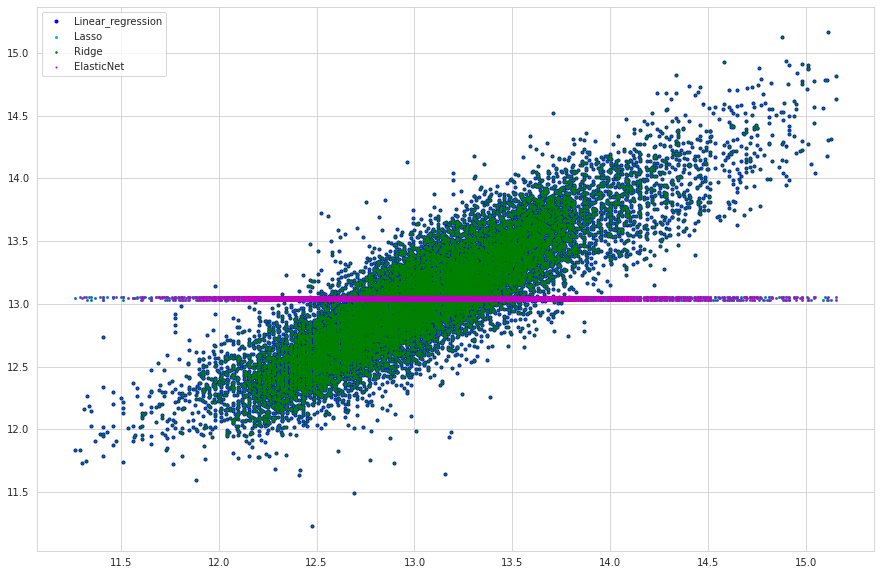

In [10]:
# Base model + StandardScaler

performance_ = {} 
prediction = []
for i in [LinearRegression(), Lasso (), Ridge (), ElasticNet ()]:
  pipe = Pipeline([('Standar_Scaler',StandardScaler()),(str(i.__class__.__name__),i)]) #model name + model Options
  model_pred = cross_val_predict(pipe, X, y, cv = KF)
  prediction.append(model_pred)
  Error = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(model_pred)))
  performance_[str(i.__class__.__name__)] =round(Error)

# Final Results 
print("There are not significant changes, except for Lasso by having 23 less MSE")
print(pd.DataFrame([performance,performance_],index= ['Squarred_error','Sqrd_scaler']).T.sort_values('Sqrd_scaler'))
plt.figure(figsize = (15,10))
print('\n')

color = (('b', 3.0,'Linear_regression'),
         ('c', 2.0,'Lasso'),
         ('g', 1.5,'Ridge'),
         ('m',1.0,'ElasticNet'))

for i,j in zip(prediction,color):
  plt.plot(y, i, marker = 'o', ls = '', c = j[0], ms =j[1], label =j[2])
  plt.legend(frameon=True)
print('In here we can see that the regularization in ElastincNet and Lasso lambda where not the ebst parameter that is why we had that horizontal')


### Hyperparameters + Pipeline + StandarScaler
1. StandarScaler
2. Pipeline
3. Lasso ,Ridge , ElasticNet Hyperparameters

***No we see some improvement ***
                  Squarred_error  MSE_Sqrd_scaler  MSE_Scaler_Hyper
LinearRegression          177735           177735            176063
ElasticNet                351412           351239            176112
Lasso                     351263           351239            176117
Ridge                     177850           177738            176202


Now we dont have the horizontal line beccause Lasso - ElastinCNet fit better the Data set due to the hyperparameter 


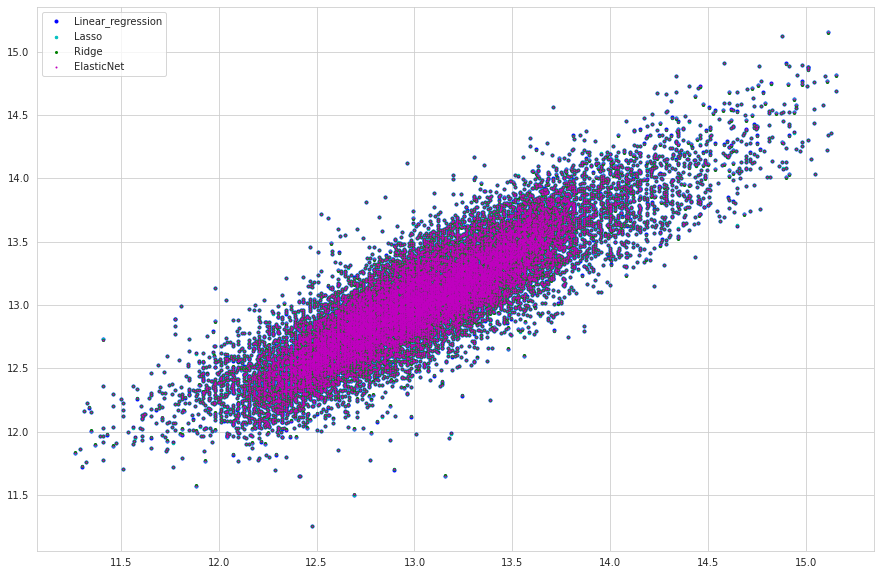

In [11]:
MSE = {}
best_parameters = {}
params_ = {}
predictions = []


# ------Hyperparameters
lasso_alpha = np.geomspace(0.0001,0.099,30)
ridge_alpha = np.geomspace(2,60,30)
Elastic_alphas = np.array([1e-5, 5e-5, 0.0001, 0.0005])
Elastic_ratios = np.linspace(0.1, 0.9, 9)

# -------------Splitting Data
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

models = [LinearRegression(), 
          LassoCV(alphas=lasso_alpha,max_iter=5e4, cv=KF),
          RidgeCV(alphas = ridge_alpha,cv=KF), 
          ElasticNetCV(alphas=Elastic_alphas, l1_ratio=Elastic_ratios,
                            max_iter=1e4,cv=KF)]

for model in models:
  pipe = Pipeline([('Standar_Scaler',StandardScaler()),(str(model.__class__.__name__),model)]) 
  pipe.fit(X,y)
  pred_ = model.predict(X)
  
  # ----------- Adding Predictions
  predictions.append(pred_)
  rmse = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(pred_)))

  if pipe[str(model.__class__.__name__)].__class__.__name__ =='LinearRegression':
    MSE[str(model.__class__.__name__)] = round(rmse)
  else:
    MSE[str(model.__class__.__name__)[:-2]] =round(rmse)
    best_parameters[str(model.__class__.__name__)] = model.alpha_
    try:
      best_parameters[str(model.__class__.__name__)+'_ratio'] = model.l1_ratio_
    except:
      pass




print("***No we see some improvement ***")
print(pd.DataFrame([performance,performance_,MSE],index= ['Squarred_error','MSE_Sqrd_scaler','MSE_Scaler_Hyper']).T.sort_values('MSE_Scaler_Hyper'))
print("\n")
plt.figure(figsize = (15,10))
color = (('b', 3.0,'Linear_regression'),
         ('c', 2.5,'Lasso'),
         ('g', 2.0,'Ridge'),
         ('m', 1.0,'ElasticNet'))

for i,j in zip(predictions,color):
  plt.plot(y, i, marker = 'o', ls = '', c = j[0], ms =j[1], label =j[2])
  plt.legend(frameon=True)
print('Now we dont have the horizontal line beccause Lasso - ElastinCNet fit better the Data set due to the hyperparameter ')



### Hyperparameters + Pipeline + StandarScaler
1. StandarScaler
2. Pipeline
3. SGD Regressor

##### Notice that in this part the hyperparameter for Lasso, Ridge and ElasticNet will be extracted from the dictionary best_parametes
- it looks like this 
* {'ElasticNetCV': 0.0005,
 'ElasticNetCV_ratio': 0.1,
 'LassoCV': 0.0001,
 'RidgeCV': 40.000000000000014}

In [12]:
model_para_dict = {
    'Linear':{'penalty':'none'},
    'Lasso':{'penalty':'l2', 'alpha':best_parameters['LassoCV']},
    'Ridge':{'penalty':'l2', 'alpha':best_parameters['RidgeCV']},
    'ElasticNet': {'penalty':'elasticnet', 
                   'alpha':best_parameters['ElasticNetCV'],
                   'l1_ratio':best_parameters['ElasticNetCV_ratio']}}
NMSE = {}
for model_label, parameters in model_para_dict.items():
  pipe =Pipeline([('StandarScaler',StandardScaler()),
                  ('SGD',SGDRegressor(max_iter=4500,**parameters))])
  model_pred = cross_val_predict(pipe, X,y, cv=KF)
  Error = np.sqrt(mean_squared_error(np.expm1(y),np.expm1(model_pred)))
  NMSE[str(model_label)] =round(Error)

NMSE

{'Linear': 181520, 'Lasso': 176253, 'Ridge': 342640, 'ElasticNet': 177159}

##### notice that SGD regressor can be set using all those algorithms Linear Regression ~ Elasticnet... The benefit of having this SGD is that we can adjust the max_iter 'which is the iteraction / running time on the data

##### also notice that from here we can use GridsearchCv to find better parameters, adjust learning rate , interception and other ... from here is up to you 

### ANN - Regression 

In [13]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
def regression (initial_layers = 16 , mid_layers = 8 ,
                drop_1 = 0 , drop_2 =0 ):

  model = Sequential([
      Dense(initial_layers, activation= 'relu'),Dropout(drop_1),
      Dense(mid_layers, activation = 'relu'),Dropout(drop_2),
      Dense(1)
      ])
  model.compile(optimizer = RMSprop(0.001),
                loss = 'mse', 
                metrics =['mae','mse'])
  return model 

def plot_model (model):
  hist = pd.DataFrame(model.history.history)
  hist['epoch'] = model.history.epoch

  f,ax = plt.subplots(1,2, figsize = (15,7))
  sns.lineplot(hist.epoch, hist.mae , ax=ax[0] , label = 'Training Error')
  sns.lineplot(hist.epoch, hist.val_mae, ax=ax[0], label = 'Validation Error')

  sns.lineplot(hist.epoch, hist.mse , ax=ax[1], label = 'Training Error')
  sns.lineplot(hist.epoch, hist.val_mse, ax=ax[1], label = 'Training Error');

Mean Abs Error: 0.17876924574375153, Mean Squared Error:0.056774675846099854


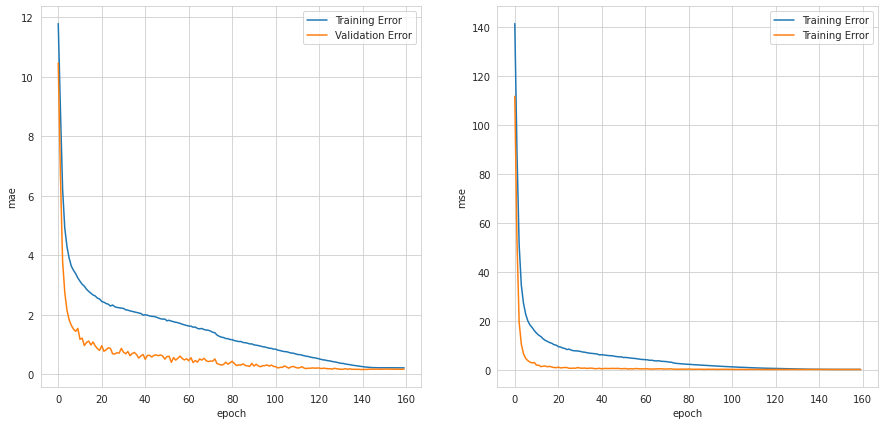

In [15]:
BATCH_SIZE = 150
EPOCHS = 500

early_stop = EarlyStopping(monitor = 'val_loss', mode='min' , patience = 20)
model = regression(15,10,0.3,0.3)
model.fit(x = X_train, y = y_train, validation_data = (X_test,y_test),
          batch_size = BATCH_SIZE , epochs = EPOCHS, verbose = 0,
          callbacks = [early_stop])
plot_model(model)
loss, mae, mse = model.evaluate(X_test,y_test, verbose = 0)
print(f"Mean Abs Error: {mae}, Mean Squared Error:{mse}")


This notebook was inspired by IBM Machine learning Courses , where I learned lot of algorithms - regression - hyperparameters and the importance of using the right algorithm for the data that we have ..!!!

Here there are some suggestions to those who want to take this notebook 
1. Find better parameters for Lasso, Ridge 
2. Adjust the Learning rate and Max_int in SGD
3. ANN - find better drop out / epochs / batch size to improve / prevent overfitting 
4. Try another normalizatin such as MaxMin 